# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()

In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]

In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]

## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))

A: 
 136245
Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))

B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


In [7]:
# for col in hour_cols:
#     XTRA[col].shift(-4)
#     XTRB[col].shift(-4)
#     XTRB[col].shift(-4)

## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

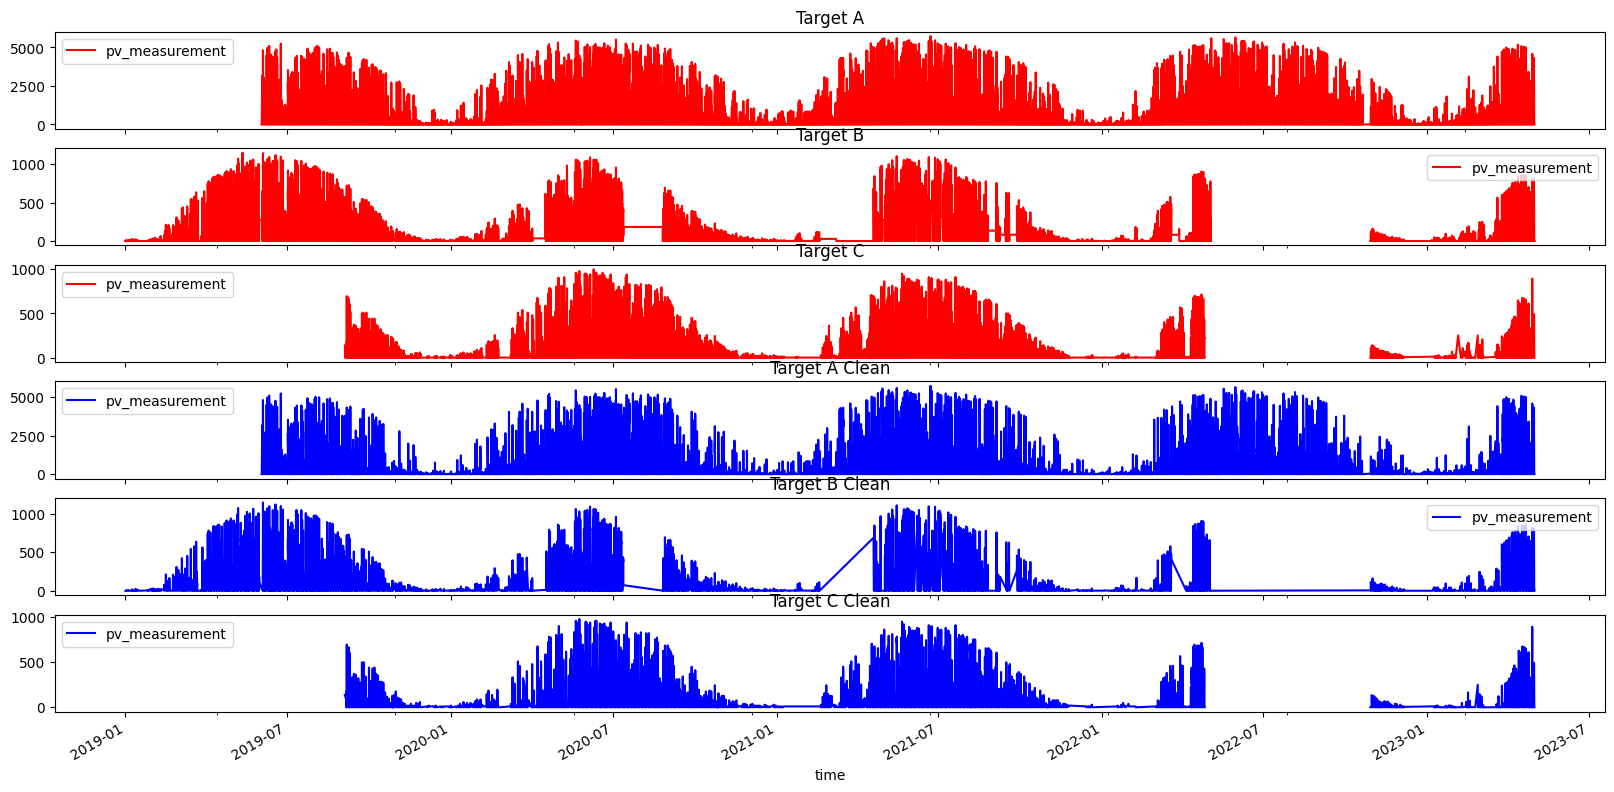

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
                zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])

In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))

x,y:  18071 18071
x,y:  12443 12443
x,y:  10129 10129


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())

18066   2023-04-30 19:00:00
18067   2023-04-30 20:00:00
18068   2023-04-30 21:00:00
18069   2023-04-30 22:00:00
18070   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
12438   2023-04-30 19:00:00
12439   2023-04-30 20:00:00
12440   2023-04-30 21:00:00
12441   2023-04-30 22:00:00
12442   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]
10124   2023-04-30 19:00:00
10125   2023-04-30 20:00:00
10126   2023-04-30 21:00:00
10127   2023-04-30 22:00:00
10128   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[us]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
    X_train[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])
    X_frames_test[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])

Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_rad:W']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_rad:W']

    X_train[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])

In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test[i].drop(columns=['air_density_2m:kgm3'], inplace=True)

In [16]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['ceiling_height_agl:m'].max())
    print(i, X_train[i]['ceiling_height_agl:m'].max())

0 11430.775
0 12005.6
1 11430.9
1 12005.7
2 11468.0
2 11982.6


Flipping this as well and replacing null with 0 might give better result. For instance null = no cluds, and by flipping the values we say that taller clouds are closer to no clouds than lower clouds. As in the real world. Simply using the highest measured ceiling height as flipping value and adding 1000 to differentiate from no clouds 

> (e.g. 100 gets flipped to 100-(max_height+1000))

In [17]:
X_train[i]['ceiling_height_agl:m'].tail(20)

10109    4022.100342
10110    4189.450195
10111    4583.450195
10112    4099.325195
10113    2434.050049
10114    1396.125000
10115    1260.025024
10116    1854.625000
10117    2856.574951
10118    3968.550049
10119    4919.075195
10120    4533.200195
10121    3356.399902
10122    2030.000000
10123    1943.750000
10124    1456.574951
10125    1476.349976
10126    1516.300049
10127    1240.599976
10128    1484.500000
Name: ceiling_height_agl:m, dtype: float32

In [18]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train)):
    X_frames_test[i]['ceiling_height_agl:m'] = X_frames_test[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train[i]['ceiling_height_agl:m']= X_train[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)

In [19]:
X_train[i]['ceiling_height_agl:m'].isna().sum()

2289

In [20]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['cloud_base_agl:m'].max())
    print(i, X_train[i]['cloud_base_agl:m'].max())

0 11256.7
0 11387.599
1 11256.8
1 11170.0
2 11467.8
2 11125.0


In [21]:
X_train[i]['cloud_base_agl:m'].tail(20)

10109     806.500000
10110     956.349976
10111    1151.574951
10112    1044.550049
10113     715.775024
10114     630.724976
10115     496.049988
10116     325.625000
10117     428.025024
10118     617.549988
10119     689.174988
10120     716.650024
10121     693.300049
10122     620.349976
10123     568.099976
10124     551.224976
10125     564.099976
10126     578.700012
10127     551.500000
10128     558.674988
Name: cloud_base_agl:m, dtype: float32

In [22]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train)):
    X_frames_test[i]['cloud_base_agl:m'] = X_frames_test[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train[i]['cloud_base_agl:m']= X_train[i]['cloud_base_agl:m'].apply(flip_ceiling_height)

In [23]:
X_train[i]['cloud_base_agl:m'].isna().sum()

873

In [24]:
print(X_frames_test[0].columns)

Index(['is_day:idx', 'is_in_shadow:idx', 'ceiling_height_agl:m',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa',
       'precip_5min:mm', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_d

## Data Cleaning

In [25]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,3525,2104,2289
cloud_base_agl:m,1322,910,873
snow_density:kgm3,17719,12166,10116


In [26]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]

,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [27]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)

# Normalizing Y and merging all X and normalized Y

In [28]:
from data_func.combine_all_frames import combine_all_frames
from data_func.combine_series import combine_series

In [29]:
X_comb = combine_all_frames(X_train)


In [30]:
NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()

Verifying we can get back to original

In [31]:
print(NYA.head(), Y_train[0].head())

0   -0.666864
1   -0.666864
2   -0.666864
3   -0.666864
4   -0.652230
Name: pv_measurement, dtype: float64 0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


In [32]:
NoYA = (NYA * Y_train[0].std())+Y_train[0].mean()
NoYA.head()

0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64

In [33]:
Y_comb = combine_series([NYA, NYB, NYC])

In [34]:
len(Y_comb)

40643

In [36]:
Y_comb.reset_index(drop=True, inplace=True)
Y_comb.tail()

40638   -0.433639
40639   -0.664875
40640   -0.679032
40641   -0.679032
40642   -0.679032
Name: pv_measurement, dtype: float64

# Training the model

In [37]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_comb, Y_comb, test_size=0.17, random_state=42)

In [49]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(x_train_a, y_train_a, left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='medium_quality', time_limit=900) #, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231110_235828"
Presets specified: ['medium_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20231110_235828"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   361.07 GB / 994.66 GB (36.3%)
Train Data Rows:    33733
Train Data Columns: 59
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.f

[1000]	valid_set's l1: 0.147764
[2000]	valid_set's l1: 0.137948
[3000]	valid_set's l1: 0.132477
[4000]	valid_set's l1: 0.12929
[5000]	valid_set's l1: 0.126804
[6000]	valid_set's l1: 0.125135
[7000]	valid_set's l1: 0.123694
[8000]	valid_set's l1: 0.122526
[9000]	valid_set's l1: 0.121274
[10000]	valid_set's l1: 0.120432


	-0.1204	 = Validation score   (-mean_absolute_error)
	56.6s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 842.45s of the 842.45s of remaining time.


[1000]	valid_set's l1: 0.134385
[2000]	valid_set's l1: 0.125322
[3000]	valid_set's l1: 0.121918
[4000]	valid_set's l1: 0.119763
[5000]	valid_set's l1: 0.118392
[6000]	valid_set's l1: 0.117575
[7000]	valid_set's l1: 0.117013
[8000]	valid_set's l1: 0.116582
[9000]	valid_set's l1: 0.116399
[10000]	valid_set's l1: 0.116193


	-0.1162	 = Validation score   (-mean_absolute_error)
	48.07s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 793.67s of the 793.67s of remaining time.
	-0.1507	 = Validation score   (-mean_absolute_error)
	26.77s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 766.57s of the 766.57s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 766.47s of the 766.47s of remaining time.
	-0.148	 = Validation score   (-mean_absolute_error)
	4.33s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 761.79s of the 761.79s of remaining time.
	-0.1599	 = Validation score   (-mean_absolute_error)
	18.46s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 743.3s of the 743.3s of remaining time.
		'Booster' object has no attribute 'best_ntree_limit'
D

[1000]	valid_set's l1: 0.120322
[2000]	valid_set's l1: 0.115154
[3000]	valid_set's l1: 0.11362
[4000]	valid_set's l1: 0.113039
[5000]	valid_set's l1: 0.112777
[6000]	valid_set's l1: 0.112624
[7000]	valid_set's l1: 0.112563
[8000]	valid_set's l1: 0.112528
[9000]	valid_set's l1: 0.112508
[10000]	valid_set's l1: 0.112497


	-0.1125	 = Validation score   (-mean_absolute_error)
	236.27s	 = Training   runtime
	0.71s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 404.16s of remaining time.
	-0.1112	 = Validation score   (-mean_absolute_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 495.96s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231110_235828")


In [39]:
y_a_test = predictor.predict(x_val_a)

In [50]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.115538,-0.111188,3.729824,1.338902,341.044623,0.011688,0.000198,0.100160,2,True,10
1,LightGBMLarge,-0.117715,-0.112496,2.114182,0.714178,236.268096,2.114182,0.714178,236.268096,1,True,9
2,LightGBM,-0.120197,-0.116191,0.835288,0.361504,48.073837,0.835288,0.361504,48.073837,1,True,4
3,LightGBMXT,-0.122348,-0.120427,0.768666,0.263022,56.602530,0.768666,0.263022,56.602530,1,True,3
4,ExtraTreesMSE,-0.152731,-0.148005,0.406548,0.038475,4.326177,0.406548,0.038475,4.326177,1,True,6
5,RandomForestMSE,-0.155074,-0.150710,0.395850,0.037669,26.767424,0.395850,0.037669,26.767424,1,True,5
6,NeuralNetFastAI,-0.165004,-0.159944,0.093866,0.013052,18.463272,0.093866,0.013052,18.463272,1,True,7
7,NeuralNetTorch,-0.173871,-0.171717,0.029931,0.016125,19.672735,0.029931,0.016125,19.672735,1,True,8
8,KNeighborsDist,-0.212176,-0.213754,1.569127,0.064305,0.026663,1.569127,0.064305,0.026663,1,True,2
9,KNeighborsUnif,-0.236488,-0.238898,1.016642,0.064322,0.026255,1.016642,0.064322,0.026255,1,True,1


In [57]:
joined_c = pd.merge(X_comb, Y_comb, left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='medium_quality', time_limit=900)#, presets='good_quality', time_limit=3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20231111_122118"
Presets specified: ['medium_quality']
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20231111_122118"
AutoGluon Version:  0.8.3b20231102
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   359.67 GB / 994.66 GB (36.2%)
Train Data Rows:    40643
Train Data Columns: 59
Label Column: pv_measurement
Preprocessing data ...
/Library/Frameworks/Python.f

[1000]	valid_set's l1: 0.151247
[2000]	valid_set's l1: 0.140646
[3000]	valid_set's l1: 0.134812
[4000]	valid_set's l1: 0.130657
[5000]	valid_set's l1: 0.128214
[6000]	valid_set's l1: 0.126178
[7000]	valid_set's l1: 0.124474
[8000]	valid_set's l1: 0.12303
[9000]	valid_set's l1: 0.121615
[10000]	valid_set's l1: 0.120782


	-0.1208	 = Validation score   (-mean_absolute_error)
	121.68s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 777.27s of the 777.27s of remaining time.


[1000]	valid_set's l1: 0.137325
[2000]	valid_set's l1: 0.128146
[3000]	valid_set's l1: 0.123558
[4000]	valid_set's l1: 0.121187
[5000]	valid_set's l1: 0.119782
[6000]	valid_set's l1: 0.118467
[7000]	valid_set's l1: 0.11767
[8000]	valid_set's l1: 0.117008
[9000]	valid_set's l1: 0.116546
[10000]	valid_set's l1: 0.116209


	-0.1162	 = Validation score   (-mean_absolute_error)
	48.31s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 728.33s of the 728.33s of remaining time.
	-0.1478	 = Validation score   (-mean_absolute_error)
	30.89s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 697.06s of the 697.06s of remaining time.
		
Fitting model: ExtraTreesMSE ... Training model for up to 696.95s of the 696.95s of remaining time.
	-0.1444	 = Validation score   (-mean_absolute_error)
	4.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 692.11s of the 692.11s of remaining time.
	-0.164	 = Validation score   (-mean_absolute_error)
	18.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 673.15s of the 673.14s of remaining time.
		'Booster' object has no attribute 'best_ntree_limit'

[1000]	valid_set's l1: 0.122362
[2000]	valid_set's l1: 0.115756
[3000]	valid_set's l1: 0.113604
[4000]	valid_set's l1: 0.112594
[5000]	valid_set's l1: 0.112181
[6000]	valid_set's l1: 0.111994
[7000]	valid_set's l1: 0.111882
[8000]	valid_set's l1: 0.111817
[9000]	valid_set's l1: 0.111783


## Evaluate

In [51]:
a_ind = x_val_a[x_val_a['location'] == 0].index
b_ind = x_val_a[x_val_a['location'] == 1].index
c_ind = x_val_a[x_val_a['location'] == 2].index

In [52]:
pred = predictor.predict(x_val_a)

In [53]:
pred.head()

9291     1.237034
2020    -0.665758
39509   -0.318048
14658   -0.204442
36427   -0.086280
Name: pv_measurement, dtype: float32

In [54]:
len(a_ind)

3048

In [55]:
len(y_val_a[a_ind])

3048

In [56]:
from sklearn.metrics import mean_absolute_error

def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()



#Up_y_val_A = upscale(y_val_a[a_ind], 0)
#Up_y_val_B = upscale(y_val_a[b_ind], 1)
#Up_y_val_C = upscale(y_val_a[c_ind], 2)

mae_a = mean_absolute_error(upscale(y_val_a[a_ind], 0), upscale(pred[a_ind], 0))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(upscale(y_val_a[b_ind], 1), upscale(pred[b_ind], 1))
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(upscale(y_val_a[c_ind], 2), upscale(pred[c_ind], 2))
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)

MAE for A:  167.64653255232363
MAE for B:  24.64656166508567
MAE for C:  24.20373496684346
Mean MAE:  72.16560972808425


In [33]:
# x_val_a

In [34]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)

In [35]:
pred = predictor.predict(X_train[0][34000:34025])

In [36]:
goal = Y_train[0][34000:34025]

In [37]:
g=34000
print(pred[34000])
for i in range(len(pred)):
    print(i, pred[i+g]-goal[i+g], pred[i+g], goal[i+g])

855.8206
0 -221.29938232421864 855.8206 1077.12
1 18.91958007812491 1486.3196 1467.4
2 -460.65625 4120.8438 4581.5
3 82.97738769531247 1221.6974 1138.72
4 -21.481171874999973 1281.7988 1303.28
5 38.22955078124983 1280.7896 1242.5600000000002
6 -30.913232421875023 778.68677 809.6
7 -25.267296142578118 278.5527 303.82
8 12.280349731445312 34.28035 22.0
9 17.357450485229492 17.35745 0.0
10 17.72382354736328 17.723824 0.0
11 17.690614700317383 17.690615 0.0
12 17.777938842773438 17.777939 0.0
13 17.626474380493164 17.626474 0.0
14 17.462055206298828 17.462055 0.0
15 16.612483978271484 16.612484 0.0
16 0.07876983642578494 43.41877 43.339999999999996
17 -18.932384033203107 138.58762 157.51999999999998
18 -46.456573486328125 256.04343 302.5
19 64.49330810546877 387.4533 322.96
20 -7.683834228515593 471.47617 479.15999999999997
21 28.764296875000014 674.9043 646.14
22 -7.923549804687468 894.73645 902.66
23 3.1628320312497635 1084.9028 1081.7400000000002
24 -10.7020117187501 1333.938 1344.64


In [38]:
print(goal[11+g], pred[11+g])

0.0 17.690615


In [39]:
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)

In [40]:
test_pred = predictor.transform_features(X_frames_test[0][0:25])

In [41]:
predictor.predict(test_pred)

34061      15.502867
34062      15.256422
34063      15.356131
34064      50.681835
34065     319.611176
34066     802.164185
34067    1696.282227
34068    3184.991455
34069    3134.169922
34070    2983.193604
34071    3639.419189
34072    3296.922852
34073    2649.825684
34074    3057.472656
34075    2572.803223
34076    1595.059082
34077    1414.158569
34078     600.350220
34079     201.429108
34080      38.868683
34081      17.521238
34082      18.215988
34083      17.210369
34084      17.085529
34085      14.099195
Name: pv_measurement, dtype: float32

In [42]:
X_train[0].tail(25)

,date_forecast,is_day:idx,is_in_shadow:idx,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_energy_X_eff_cloud_cover,COMB_sun_elevation_air_density
34036,2023-04-29 23:00:00,0,1,1.27725,4197.399902,0.000000e+00,0.000000,750.224976,271.950012,0.000000,...,0,0,0,0,0,1005.168762,0.000000,0.000000,0.000000e+00,-0.268880
34037,2023-04-30 00:00:00,0,1,1.28100,2507.550049,0.000000e+00,0.000000,1075.074951,271.700012,0.000000,...,0,0,0,0,0,1006.143738,0.000000,0.000000,-0.000000e+00,-0.241106
34038,2023-04-30 01:00:00,0,1,1.27850,2224.600098,0.000000e+00,0.000000,949.799988,271.650024,0.000000,...,0,0,0,0,0,1005.862549,0.000000,0.000000,0.000000e+00,-0.182351
34039,2023-04-30 02:00:00,0,1,1.27700,2318.500000,0.000000e+00,0.000000,1700.574951,271.600006,0.000000,...,0,0,0,0,0,1005.606201,0.000000,0.000000,0.000000e+00,-0.091647
34040,2023-04-30 03:00:00,1,0,1.27600,3395.800049,8.052975e+03,9.950000,2417.175049,271.500000,8.025000,...,0,0,0,0,0,1005.299988,4.950000,8901.988281,3.746647e+05,0.024902
34041,2023-04-30 04:00:00,1,0,1.27350,2289.975098,1.307704e+05,72.675003,932.099976,271.399994,43.875000,...,0,0,0,0,0,1004.962463,30.100000,63076.222656,3.602724e+06,0.159154
34042,2023-04-30 05:00:00,1,0,1.26950,4014.899902,4.540071e+05,185.199997,919.950012,271.575012,97.324997,...,0,1,0,0,0,1004.612549,63.837498,169100.500000,2.383544e+05,0.301333
34043,2023-04-30 06:00:00,1,0,1.26700,2650.449951,9.014685e+05,316.549988,1157.025024,272.000000,140.500000,...,0,1,0,0,0,1004.443787,80.599998,260012.781250,4.507342e+06,0.442149
34044,2023-04-30 07:00:00,1,0,1.26550,1734.449951,1.374201e+06,445.125000,1026.599976,272.750000,198.100006,...,0,1,0,0,0,1004.731262,135.950012,389823.968750,1.621557e+07,0.572187
34045,2023-04-30 08:00:00,1,0,1.26475,2351.500000,1.810678e+06,557.125000,732.599976,273.325012,228.074997,...,0,1,0,0,0,1005.337463,194.524994,594866.000000,1.104513e+07,0.682670


In [43]:
X_frames_test[0].head(25)

,date_forecast,is_day:idx,is_in_shadow:idx,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_energy_X_eff_cloud_cover,COMB_sun_elevation_air_density
34061,2023-05-01 00:00:00,0,1,1.28675,912.700012,0.000000e+00,0.000000,1061.550049,271.650024,0.000000,...,0,0.0,0.0,0.0,0,1008.531250,0.000000,0.000000,0.000000e+00,-0.235397
34062,2023-05-01 01:00:00,0,1,1.28600,1482.099976,0.000000e+00,0.000000,1075.100098,271.450012,0.000000,...,0,0.0,0.0,0.0,0,1008.025024,0.000000,0.000000,0.000000e+00,-0.176631
34063,2023-05-01 02:00:00,0,1,1.28375,1791.300049,0.000000e+00,0.000000,1200.400024,271.049988,0.000000,...,0,0.0,0.0,0.0,0,1007.506287,0.000000,0.000000,0.000000e+00,-0.085426
34064,2023-05-01 03:00:00,1,0,1.28200,2312.875000,1.012442e+04,11.675000,1179.849976,270.649994,9.375000,...,0,0.0,0.0,0.0,0,1006.974976,5.737500,10305.288086,3.179070e+05,0.031602
34065,2023-05-01 04:00:00,1,0,1.28100,2198.299805,1.417486e+05,76.875000,920.049988,270.375000,47.400002,...,0,0.0,0.0,0.0,0,1006.518738,36.425003,75890.453125,4.776927e+06,0.166506
34066,2023-05-01 05:00:00,1,0,1.27600,1957.625000,4.716072e+05,190.574997,1419.300049,270.549988,86.425003,...,0,0.0,0.0,0.0,0,1006.106201,87.325005,222806.765625,1.222642e+07,0.309076
34067,2023-05-01 06:00:00,1,0,1.26825,1903.300049,9.212486e+05,322.149994,1299.400024,270.824982,111.074997,...,0,0.0,0.0,0.0,0,1005.718750,146.287506,420540.500000,3.818575e+07,0.448538
34068,2023-05-01 07:00:00,1,0,1.26250,20000.000000,1.394139e+06,450.575012,743.299988,270.899994,130.100006,...,0,0.0,0.0,0.0,0,1005.412476,198.425003,620502.375000,7.172847e+07,0.576532
34069,2023-05-01 08:00:00,1,0,1.25975,1381.199829,1.830129e+06,562.450012,805.375000,271.024994,159.225006,...,0,0.0,0.0,0.0,0,1005.137512,237.212509,784185.750000,7.123778e+07,0.685459
34070,2023-05-01 09:00:00,1,0,1.25850,1429.824951,2.187716e+06,647.900024,884.950012,271.049988,187.600006,...,0,0.0,0.0,0.0,0,1004.956238,260.987488,896780.687500,4.348087e+07,0.767776


In [41]:
#predictions before full training
pred_split_a = predictor.predict(X_frames_test[0])
pred_split_b = predictor_b.predict(X_frames_test[1])
pred_split_c = predictor_c.predict(X_frames_test[2])

# Make predictions

In [42]:
# Do some more stuff
y_pred = np.concatenate((pred_split_a, pred_split_b, pred_split_c), axis=0)

print(len(y_pred))

2160


In [43]:
y_pred[0:10]

array([  -4.8838625,   -9.082048 ,  -10.247913 ,   28.13417  ,
        258.2115   ,  701.33295  , 1603.6904   , 2987.644    ,
       2539.2278   , 1801.0106   ], dtype=float32)

In [44]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0

# Evaluate prediction

# Create submission

In [45]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_med_300_full_submission.csv', index=False)

In [ ]:
combine = combined
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_ag_xg_2.csv", index = False)